In [1]:
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize

In [3]:
import os
import sys
import random
import math
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import cv2

In [4]:
class LoculesConfig(Config):
    NAME = "locules"
    BACKBONE = "resnet50"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2 + 1
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0001

config = LoculesConfig()
config.display()
    


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        35
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [7]:
from PIL import Image, ImageDraw
import json

class DurianLoculeDataset(utils.Dataset):

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "locules"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)
        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

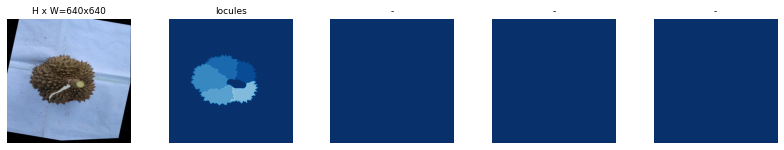

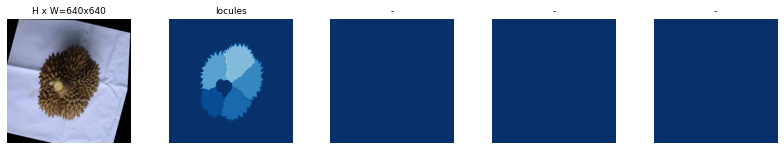

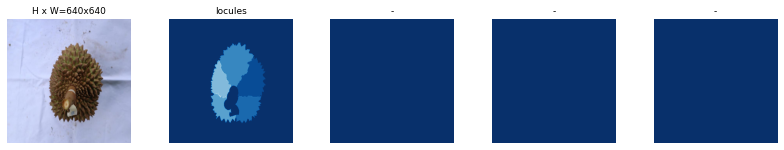

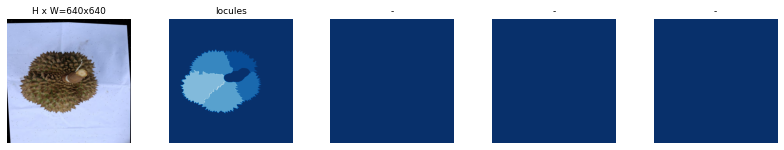

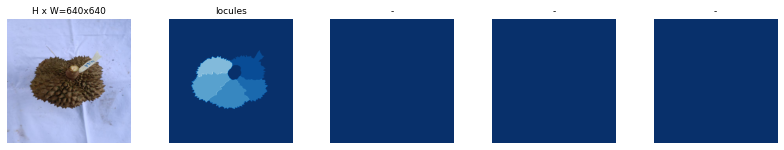

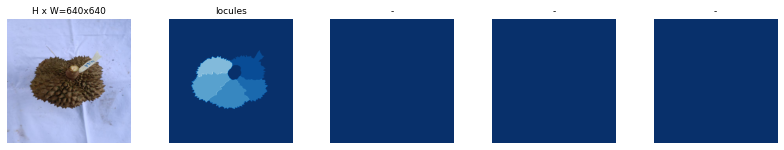

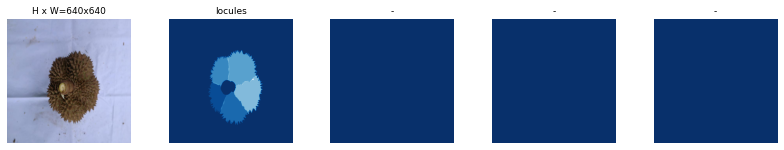

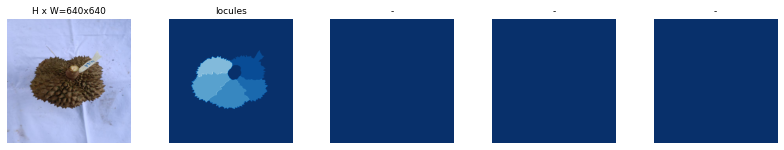

In [13]:
import numpy as np

dataset_train = DurianLoculeDataset()
dataset_train.load_data('./dataset/dataset/locule-4/train/_annotations.coco.json', './dataset/dataset/locule-4/train/')
dataset_train.prepare()

dataset_val = DurianLoculeDataset()
dataset_val.load_data('./dataset/dataset/locule-4/valid/_annotations.coco.json', './dataset/dataset/locule-4/valid/')
dataset_val.prepare()

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    
dataset = dataset_val
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [14]:
print(os.listdir())

['train.ipynb', 'requirements.txt', '.env', 'mask_rcnn_coco.h5', 'main.ipynb', 'mrcnn', 'dataset', 'logs', 'docker-compose.yml', 'Dockerfile', '.ipynb_checkpoints']


In [15]:
import os
ROOT_DIR = os.path.abspath("./")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_MODEL_PATH)
print(MODEL_DIR)

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Train from coco checkpoint
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

/app/mask_rcnn_coco.h5
/app/logs


In [16]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /app/logs/locules20241028T2205/mask_rcnn_locules_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistribu

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier_1/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/grad

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 1.7522 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.3514 - mrcnn_class_loss: 0.3357 - mrcnn_bbox_loss: 0.5102 - mrcnn_mask_loss: 0.5142

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



100/100 [==============================] - 69s 656ms/step - batch: 49.5000 - size: 1.0000 - loss: 1.7522 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.3514 - mrcnn_class_loss: 0.3357 - mrcnn_bbox_loss: 0.5102 - mrcnn_mask_loss: 0.5142 - val_loss: 1.3067 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 0.3192 - val_mrcnn_class_loss: 0.2046 - val_mrcnn_bbox_loss: 0.3779 - val_mrcnn_mask_loss: 0.3886


Test/visualizing the model

In [17]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = f"{ROOT_DIR}/dataset/dataset/locule-4"
print(CUSTOM_DIR)
dataset_test = DurianLoculeDataset()
dataset_test.load_data('./dataset/dataset/locule-4/train/_annotations.coco.json', './dataset/dataset/locule-4/train/')
dataset_test.prepare()


/app/dataset/dataset/locule-4


In [18]:
test_config = LoculesConfig()
# model = modellib.MaskRCNN(mode="inference", config=config, model_dir="./logs/locules20241028T2112/mask_rcnn_locules_0003.h5")
test_model = modellib.MaskRCNN(mode="inference", config=test_config, model_dir=MODEL_DIR)

WEIGHTS_PATH = "./logs/locules20241028T2112/mask_rcnn_locules_0003.h5"

Instructions for updating:
Use fn_output_signature instead


In [19]:
print("Loading weights ", WEIGHTS_PATH)
test_model.load_weights(WEIGHTS_PATH, by_name=True)

Loading weights  ./logs/locules20241028T2112/mask_rcnn_locules_0003.h5
Re-starting from epoch 3


In [20]:
#RUN DETECTION
image_id = random.choice(dataset_test.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset_test, test_config, image_id)
info = dataset_test.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = test_model.detect([image], verbose=1)

image id is : 201
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


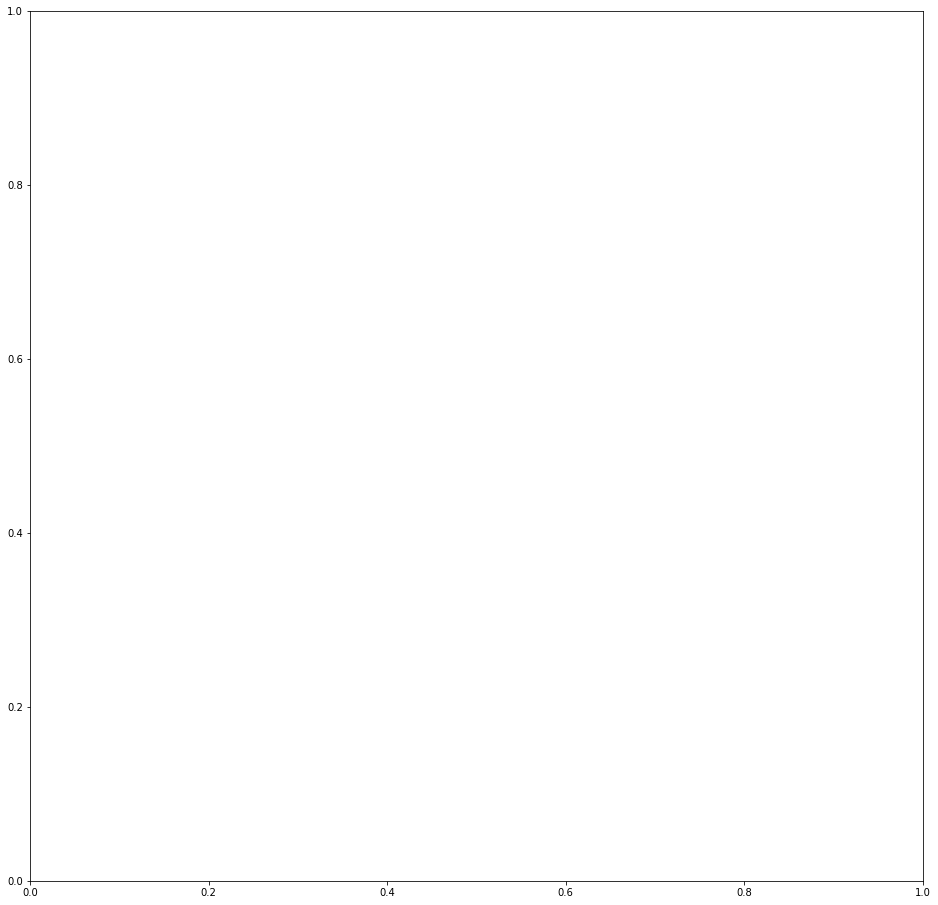

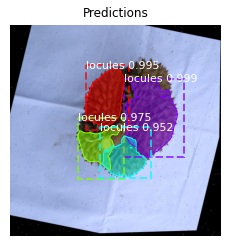

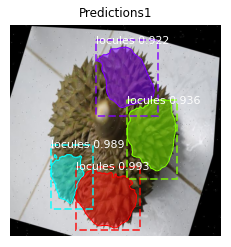

In [21]:
import matplotlib.image as mpimg
# # Display results
# x = get_ax(1)
# r = results[0]
# ax = plt.gca()
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_test.class_names, r['scores'], figAx=ax, title="Predictions")
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# IMAGE="./dataset/dataset/locule-4/train/27-09-2023_DSLR_CLASS2-MIDRIPE_5D-13_05_03_JPG.rf.71de4574f5397e2cc69c038e51cc0774.jpg"

# # This is for predicting images which are not present in dataset
# path_to_new_image = IMAGE # Change this
# image1 = mpimg.imread(path_to_new_image)

# # Run object detection
# print(len([image1]))
# results1 = model.detect([image1], verbose=1)

# # Display results
# ax = get_ax(1)
# r1 = results1[0]
# visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
# dataset_test.class_names, r1['scores'], figAx=ax, title="Predictions1")

# Display results
x = get_ax(1)
r = results[0]

# Create figure and axis for passing as figAx
fig, ax = plt.subplots(1)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_test.class_names, r['scores'], figAx=(fig, ax), title="Predictions")

# Logging
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

IMAGE = "./dataset/dataset/locule-4/train/27-09-2023_DSLR_CLASS2-MIDRIPE_5D-13_05_03_JPG.rf.71de4574f5397e2cc69c038e51cc0774.jpg"

# This is for predicting images not present in the dataset
path_to_new_image = IMAGE  # Change this if needed
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = test_model.detect([image1], verbose=1)

# Display results for the new image
fig, ax = plt.subplots(1)  # Create new figure and axis
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset_test.class_names, r1['scores'], figAx=(fig, ax), title="Predictions1")
